# **Digital Signal and Image Management - 2D Signal Processing**<br/>

---

#Facial Expression Recognition

Authors:

Luca Galli - 905236 | Davide Ronchi - 903320

---



# Contents

This project aims to build a facial expression recognition system using the [FER](https://www.kaggle.com/datasets/msambare/fer2013) and [FER+](https://github.com/microsoft/FERPlus) datasets. The idea is to train a model that will be able to predict the emotion expressed in a picture of a human face.

Since emotions expressed by a human face cannot be established objectively, the approach will not be to classify a picture of a face with a particular emotion, but rather to estimate an emotion probability distribution associated with a face. For this reason, we will use the images contained in the FER dataset and the labels in the FER+ dataset. FER+ provides a set of new labels for the standard Emotion FER dataset: Each image has been labeled by 10 crowd-sourced taggers and thus is associated with an emotion "distribution".

We start by loading and exploring the datasets, understanding their structure and contents.

Then perform data cleaning steps to remove irrelevant or low-quality data, such as images labeled as "NF" (not a face) and empty images.

The cleaned data is split into training, validation, and testing sets to prepare for model training.

Finally, we explain how we perform data augmentation, by applyin different typer of random transformations, in order to improve the robustness and generalization ability of the model.

# Importing Libraries

In [ ]:
# General
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import pandas as pd
import scipy
import os, os.path
from io import StringIO
import re
import seaborn as sns
from tqdm import tqdm
import pickle
from PIL import Image
import tarfile
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder

# Model building
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Image processing
import cv2 as cv

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Data Exploration

## Data Loading

In [ ]:
# # open file
# file = tarfile.open('/datasets/1/fer2013.tar.gz')

# # extracting file
# file.extractall('/work/fer2013')

# file.close()

In [ ]:
base_path = "/content/drive/MyDrive/DSaIM_project/2D/"

In [ ]:
fer2013 = pd.read_csv(base_path + 'Data/fer2013/fer2013.csv')
fer2013new = pd.read_csv(base_path + 'Data/fer2013new.csv')

`fer2013` contains the FER dataset. It has 3 columns:
  - *emotion*: contains an integer that represent the corresponding emotion.
  - *pixels*: contains a list of integers, that is the flattened images.
  - *Usage*: that indicates whether to use the image as a training, test or validation image.  

In [ ]:
fer2013.head()

,emotion,pixels,Usage
0,0,70 80 82 72 58 58 60 63 54 58 60 48 89 115 121...,Training
1,0,151 150 147 155 148 133 111 140 170 174 182 15...,Training
2,2,231 212 156 164 174 138 161 173 182 200 106 38...,Training
3,4,24 32 36 30 32 23 19 20 30 41 21 22 32 34 21 1...,Training
4,6,4 0 0 0 0 0 0 0 0 0 0 0 3 15 23 28 48 50 58 84...,Training


In the FER+ dataframe `fer2013new` we have a column for each emotion

In [ ]:
fer2013new.head()

,Usage,Image name,neutral,happiness,surprise,sadness,anger,disgust,fear,contempt,unknown,NF
0,Training,fer0000000.png,4,0,0,1,3,2,0,0,0,0
1,Training,fer0000001.png,6,0,1,1,0,0,0,0,2,0
2,Training,fer0000002.png,5,0,0,3,1,0,0,0,1,0
3,Training,fer0000003.png,4,0,0,4,1,0,0,0,1,0
4,Training,fer0000004.png,9,0,0,1,0,0,0,0,0,0


We see that both dataframes have the same n° of images:

In [ ]:
print(f"Number of rows in the 'fer2013' dataframe: \t{fer2013.shape[0]}")
print(f"Number of rows in the 'fer2013new' dataframe: \t{fer2013new.shape[0]}")

Number of rows in the 'fer2013' dataframe: 	35887
Number of rows in the 'fer2013new' dataframe: 	35887


### FER

In [ ]:
# Extract images
h = 48
w = 48
n_images = len(fer2013)

images = np.zeros((n_images, h, w))

for j in range(n_images):
    images[j] = np.fromstring(fer2013['pixels'][j], dtype=int, sep=' ').reshape(h,w)

# Extract FER labels
fer_labels_dummy = np.array(fer2013['emotion'])

We have 7 different emotion labels in the `fer2013` dataframe

In [ ]:
np.unique(fer_labels_dummy)

array([0, 1, 2, 3, 4, 5, 6])

The corresponding labels are: \
0.   'angry'
1.   'disgust'
2.   'fear'
3.   'happy'
4.   'sad'
5.   'surprise'
6.   'neutral'

We define a function to get this label given the corresponding index

In [ ]:
FER_labels_string = ['angry', 'disgust', 'fear', 'happy', 'sad', 'surprise', 'neutral']

def get_emotion(label_number):
    if label_number in range(0,len(FER_labels_string)):
        return FER_labels_string[label_number]
    else:
        return "Invalid emotion"

In [ ]:
def get_image(index):
    plt.figure(figsize=(3,3))
    plt.imshow(images[index], cmap='gray')
    plt.suptitle(f"Image {index}", fontsize=16)
    plt.title(f"Emotion label is {fer_labels_dummy[index]}: {get_emotion(fer_labels_dummy[index])}")
    plt.axis('off')
    plt.tight_layout()
    plt.show()

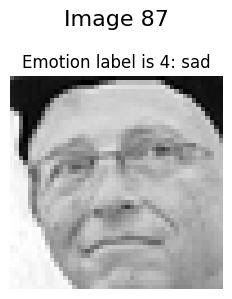

In [ ]:
get_image(87)

### FER+

`usage_list` will be a list containing the usage of each image:
* "Training" = Training data;
* "PublicTest" = Validation data;
* "PrivateTest" = Testing data

In [ ]:
usage_list = np.array(fer2013new['Usage'])

In the FER+ dataset, each image has been labeled by 10 crowd-sourced taggers, which provide better quality ground truth for still image emotion than the original FER labels. This is also useful if the aim is to predict a probability distribution of emotions, instead of performing a multiple labels classification.

In [ ]:
FERPLUS_labels_string = ['neutral', 'happiness', 'surprise', 'sadness', 'anger', 'disgust', 'fear', 'contempt', 'unknown', 'NF']
ferplus_labels_dummy = np.array(fer2013new[FERPLUS_labels_string])

In [ ]:
fer2013new.iloc[0]

Usage               Training
Image name    fer0000000.png
neutral                    4
happiness                  0
surprise                   0
sadness                    1
anger                      3
disgust                    2
fear                       0
contempt                   0
unknown                    0
NF                         0
Name: 0, dtype: object

We see that for each label is associated a number, which represent the n° of votes received by that label.

In [ ]:
ferplus_labels_dummy[0]

array([4, 0, 0, 1, 3, 2, 0, 0, 0, 0])

In [ ]:
def get_image_plus(index):
    fig = plt.figure(figsize=(6, 3))
    gs = gridspec.GridSpec(1, 2, width_ratios=[2, 1])

    # Plot image
    ax0 = plt.subplot(gs[0])
    ax0.set_title(f"Image {index}", fontsize=16)
    ax0.imshow(np.asarray(images[index]), cmap='gray')
    ax0.axis('off')

    # Plot labels
    ax1 = plt.subplot(gs[1])
    ax1.set_title("Emotions", fontsize=16)
    ax1.set_xticks([])
    ax1.set_yticks([])
    ax1.set_frame_on(False)
    space=0
    for i, s in enumerate(FERPLUS_labels_string):
        if ferplus_labels_dummy[index][i] != 0:
            ax1.text(0.1, 0.95 - 0.1 * space, f"{ferplus_labels_dummy[index][i]/len(FERPLUS_labels_string)*100:.0f}%  {s}", fontsize=12, va='top')
            space +=1
    plt.show()

Plot example images

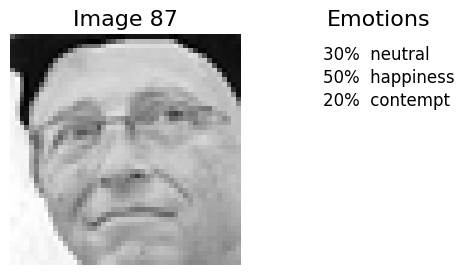

In [ ]:
get_image_plus(87)

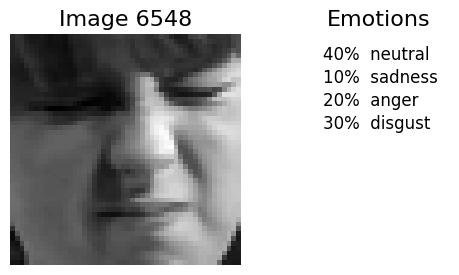

In [ ]:
get_image_plus(6548)

# Data Cleaning

In [ ]:
fer2013new.head()

,Usage,Image name,neutral,happiness,surprise,sadness,anger,disgust,fear,contempt,unknown,NF
0,Training,fer0000000.png,4,0,0,1,3,2,0,0,0,0
1,Training,fer0000001.png,6,0,1,1,0,0,0,0,2,0
2,Training,fer0000002.png,5,0,0,3,1,0,0,0,1,0
3,Training,fer0000003.png,4,0,0,4,1,0,0,0,1,0
4,Training,fer0000004.png,9,0,0,1,0,0,0,0,0,0


We want to remove all the rows labeled as "**`NF`**"

In [ ]:
fer2013new[fer2013new['NF'] > 0]

,Usage,Image name,neutral,happiness,surprise,sadness,anger,disgust,fear,contempt,unknown,NF
17,Training,NaN,0,0,0,0,0,0,0,0,0,10
23,Training,NaN,0,0,0,0,0,0,0,0,0,10
59,Training,NaN,0,0,0,0,0,0,0,0,0,10
170,Training,NaN,0,0,0,0,0,0,0,0,0,10
501,Training,NaN,0,0,0,0,0,0,0,0,0,10
...,...,...,...,...,...,...,...,...,...,...,...,...
35676,PrivateTest,fer0035592.png,0,3,0,4,0,0,1,0,1,1
35740,PrivateTest,fer0035656.png,1,1,5,2,0,0,0,0,0,1
35743,PrivateTest,NaN,0,0,0,0,0,0,0,0,0,10
35825,PrivateTest,NaN,0,0,0,0,0,0,0,0,0,10


## NF removal

First we select the row indeces of the dataframe `fer2013new` where the value of `'NF' > 0`
Then we create a new variable called


In [ ]:
NF_indeces = fer2013new[fer2013new['NF'] > 0].index.tolist()

print(f'{len(NF_indeces)} out of {len(images)} images have NF > 0 and will be removed\n')

349 out of 35887 images have NF > 0 and will be removed



In [ ]:
mask_to_remove = ~fer2013new.index.isin(NF_indeces)

# Use boolean indexing to select only the rows that are True in the mask
fer2013new_clean = fer2013new[mask_to_remove]

images_clean = np.delete(images, NF_indeces, axis = 0)
ferplus_labels_dummy_clean = np.delete(ferplus_labels_dummy, NF_indeces, axis = 0)
usage_list_clean = np.delete(usage_list, NF_indeces, axis = 0)

print(f'New dataset size is {len(images_clean)}')

New dataset size is 35538


## Removing empty images

If an image contains just 1 unique value it will have just one color and will be considered empty

In [ ]:
empty_indeces = []
for i, image in enumerate(images):
  if int(np.unique(image).shape[0]) == 1:
    empty_indeces.append(i)

empty_indeces

[6458,
 7629,
 10423,
 11286,
 13148,
 13402,
 13988,
 15894,
 22198,
 22927,
 28601,
 30002]

In [ ]:
print(f"{len(empty_indeces)} empty images have been found and will be removed")

12 empty images have been found and will be removed


In [ ]:
mask_to_remove = ~fer2013new_clean.index.isin(empty_indeces)

# Use boolean indexing to select only the rows that are True in the mask
fer2013new_clean = fer2013new_clean[mask_to_remove]

images_clean = np.delete(images_clean, empty_indeces, axis = 0)
ferplus_labels_dummy_clean = np.delete(ferplus_labels_dummy_clean, empty_indeces, axis = 0)
usage_list_clean = np.delete(usage_list_clean, empty_indeces, axis = 0)

print(f'New dataset size is {len(images_clean)}')

New dataset size is 35526


In [ ]:
ferplus_labels_dummy_clean[0]

array([4, 0, 0, 1, 3, 2, 0, 0, 0, 0])

## Train-Test split

-   "Training" = Training data,
-   "PublicTest" = validation data,
-   "PrivateTest" = testing data
  
Training_n = 28709, Validation = Testing = 3589

In [ ]:
np.where(usage_list_clean == 'PublicTest')[0]

array([28442, 28443, 28444, ..., 32006, 32007, 32008])

In [ ]:
train_indeces = np.where(usage_list_clean == 'Training')[0]
val_indeces = np.where(usage_list_clean == 'PublicTest')[0]
test_indeces = np.where(usage_list_clean == 'PrivateTest')[0]

In [ ]:
X_train = images_clean[train_indeces]
y_train = ferplus_labels_dummy_clean[train_indeces]

X_val = images_clean[val_indeces]
y_val = ferplus_labels_dummy_clean[val_indeces]

X_test = images_clean[test_indeces]
y_test = ferplus_labels_dummy_clean[test_indeces]

In [ ]:
print(f"X_train:\t{X_train.shape}")
print(f"y_train:\t{y_train.shape}")
print(f"X_val:\t\t{X_val.shape}")
print(f"y_val:\t\t{y_val.shape}")
print(f"X_test:\t\t{X_test.shape}")
print(f"y_test:\t\t{y_test.shape}")

X_train:	(28442, 48, 48)
y_train:	(28442, 10)
X_val:		(3567, 48, 48)
y_val:		(3567, 10)
X_test:		(3517, 48, 48)
y_test:		(3517, 10)


In [ ]:
# Normalizing y_train, y_test, y_val
y_train = y_train/10
y_val = y_val/10
y_test = y_test/10

In [ ]:
all_last_elements_zero = np.all(y_train[:, -1] == 0)

print(f"Last elements in y_train == 0: {all_last_elements_zero}")

Last elements in y_train == 0: True


In [ ]:
y_train[0][:-1]

array([0.4, 0. , 0. , 0.1, 0.3, 0.2, 0. , 0. , 0. ])

Checking if the sum of probabilities equals one in each element of `y_train`, `y_val`, `y_test`

In [ ]:
flag_train = True
flag_val = True
flag_test = True

for i in range(len(y_train)):
  if np.sum(y_train[i][:-1]) == 0:
    flag_train = False
    break
for i in range(len(y_val)):
  if np.sum(y_val[i][:-1]) == 0:
    flag_val = False
    break
for i in range(len(y_test)):
  if np.sum(y_test[i][:-1]) == 0:
    flag_test = False
    break

print(f"Check train set: \t{flag_train}")
print(f"Check validation set: \t{flag_val}")
print(f"Check test set: \t{flag_test}")

Check train set: 	True
Check validation set: 	True
Check test set: 	True


In [ ]:
y_train[0]

array([0.4, 0. , 0. , 0.1, 0.3, 0.2, 0. , 0. , 0. , 0. ])

In [ ]:
print(f"X_train:\t{X_train.shape}")
print(f"y_train:\t{y_train.shape}")
print(f"X_val:\t\t{X_val.shape}")
print(f"y_val:\t\t{y_val.shape}")
print(f"X_test:\t\t{X_test.shape}")
print(f"y_test:\t\t{y_test.shape}")

X_train:	(28442, 48, 48)
y_train:	(28442, 10)
X_val:		(3567, 48, 48)
y_val:		(3567, 10)
X_test:		(3517, 48, 48)
y_test:		(3517, 10)


In [ ]:
# Remove last element in y_train, y_val, y_test, that correspond to class (NF) -> is not present anymore
y_train = y_train[:, :-1]
y_val = y_val[:, :-1]
y_test = y_test[:, :-1]

In [ ]:
print(f"X_train:\t{X_train.shape}")
print(f"y_train:\t{y_train.shape}")
print(f"X_val:\t\t{X_val.shape}")
print(f"y_val:\t\t{y_val.shape}")
print(f"X_test:\t\t{X_test.shape}")
print(f"y_test:\t\t{y_test.shape}")

X_train:	(28442, 48, 48)
y_train:	(28442, 9)
X_val:		(3567, 48, 48)
y_val:		(3567, 9)
X_test:		(3517, 48, 48)
y_test:		(3517, 9)


In [ ]:
with open(base_path + 'Data/y_train.pkl', 'wb') as f:
    pickle.dump(y_train, f)

In [ ]:
with open(base_path + 'Data/y_val.pkl', 'wb') as f:
    pickle.dump(y_val, f)

In [ ]:
with open(base_path + 'Data/y_test.pkl', 'wb') as f:
    pickle.dump(y_test, f)

# Data Augmentation

Also to Train a more robust model we perform data augmentation with the following transformations:

In [ ]:
# Create an ImageDataGenerator for data augmentation
datagen = ImageDataGenerator(
    rotation_range=15,       # randomly rotate images by 15 degrees
    width_shift_range=0.1,   # randomly shift images horizontally by up to 10%
    height_shift_range=0.1,  # randomly shift images vertically by up to 10%
    shear_range=0.1,         # randomly apply shear transformation with a maximum shear intensity of 10%
    zoom_range=0.1,          # randomly zoom into images by up to 10%
    horizontal_flip=True,    # randomly flip images horizontally
    fill_mode='nearest'      # fill in newly created pixels after rotation or width/height shift
)

In [ ]:
X_train = X_train.reshape(-1, 48, 48, 1)
X_val = X_val.reshape(-1, 48, 48, 1)
X_test = X_test.reshape(-1, 48, 48, 1)

Below we show example of possible transformations applied to the dataset.

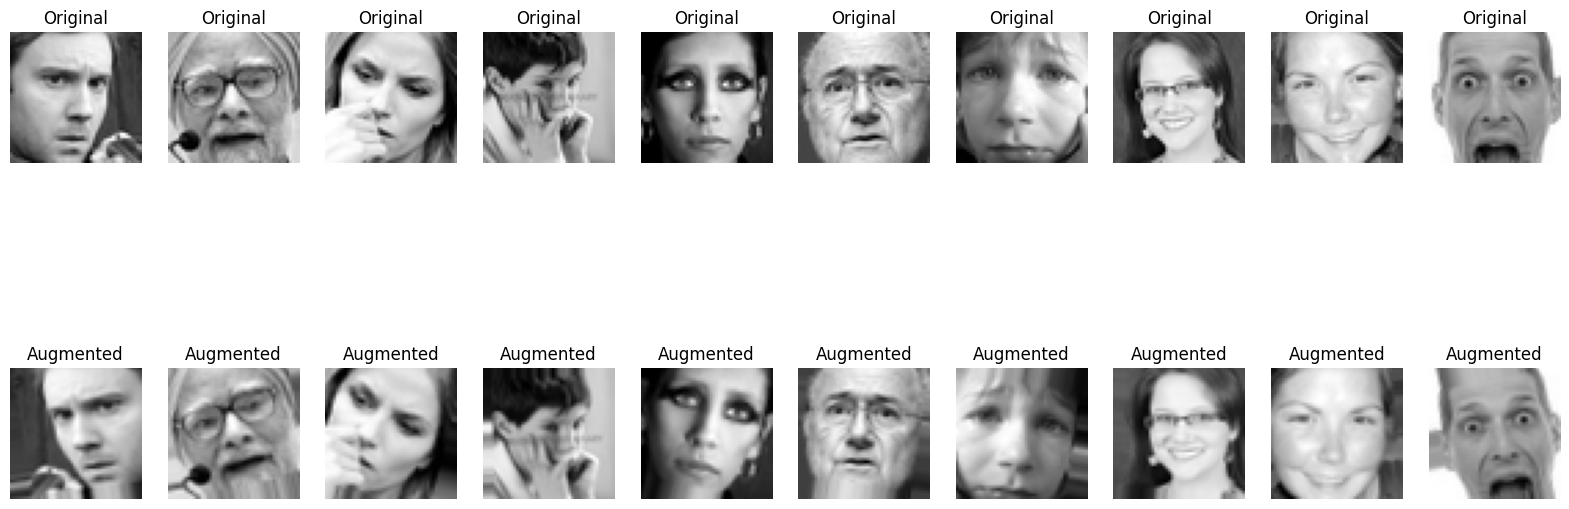

In [ ]:
# Generate augmented images from the training data
augmented_images = next(datagen.flow(X_train, y_train, batch_size=20, shuffle=False))

# Plot original and augmented images
plt.figure(figsize=(20, 8))
for i in range(10):
    # Plot original image
    plt.subplot(2, 10, i+1)
    plt.imshow(X_train[i], cmap='gray')
    plt.title('Original')
    plt.axis('off')

    # Plot augmented image
    plt.subplot(2, 10, i+11)
    plt.imshow(augmented_images[0][i], cmap='gray')
    plt.title('Augmented')
    plt.axis('off')

plt.show()